face_recognition

In [1]:
from google.colab import drive
drive.mount("/content/gdive/")

Mounted at /content/gdive/


In [2]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

use_gpu = torch.cuda.is_available()
use_gpu

True

In [3]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

In [4]:
#models.__dict__['convnext_small'](True)

In [5]:
!unzip "/content/gdive/MyDrive/Gautam Cattle/buffalo_data_final_7th_march23.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/buffalo_data/train/4/IMG_20200912_162517.jpg  
   creating: content/buffalo_data/train/165/
  inflating: content/buffalo_data/train/165/frame47.jpg  
  inflating: content/buffalo_data/train/165/frame10.jpg  
  inflating: content/buffalo_data/train/165/frame14.jpg  
  inflating: content/buffalo_data/train/165/frame36.jpg  
  inflating: content/buffalo_data/train/165/frame56.jpg  
  inflating: content/buffalo_data/train/165/frame42.jpg  
  inflating: content/buffalo_data/train/165/frame54.jpg  
  inflating: content/buffalo_data/train/165/frame50.jpg  
  inflating: content/buffalo_data/train/165/frame48.jpg  
  inflating: content/buffalo_data/train/165/frame38.jpg  
  inflating: content/buffalo_data/train/165/frame40.jpg  
  inflating: content/buffalo_data/train/165/frame6.jpg  
  inflating: content/buffalo_data/train/165/frame59.jpg  
  inflating: content/buffalo_data/train/165/frame21.jpg  
  inflating: content/buff

In [6]:
#DATA_DIR = '/content/gdive/MyDrive/data-sets/face-data-set/'
train_dir = f'/content/content/buffalo_data/train'
valid_dir = f'/content/content/buffalo_data/val'

sz = 224
batch_size = 16
embed_size = 256
num_epochs = 13

cnn_name = 'convnext_small'

In [7]:
class TripletNetworkDataset(Dataset):

    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()

    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]

        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])

        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')

        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)

        return anc_img, pos_img, neg_img

    def __len__(self):
        return len(self.imgs)

In [8]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    #transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])


face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)


valid_tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)


torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224])


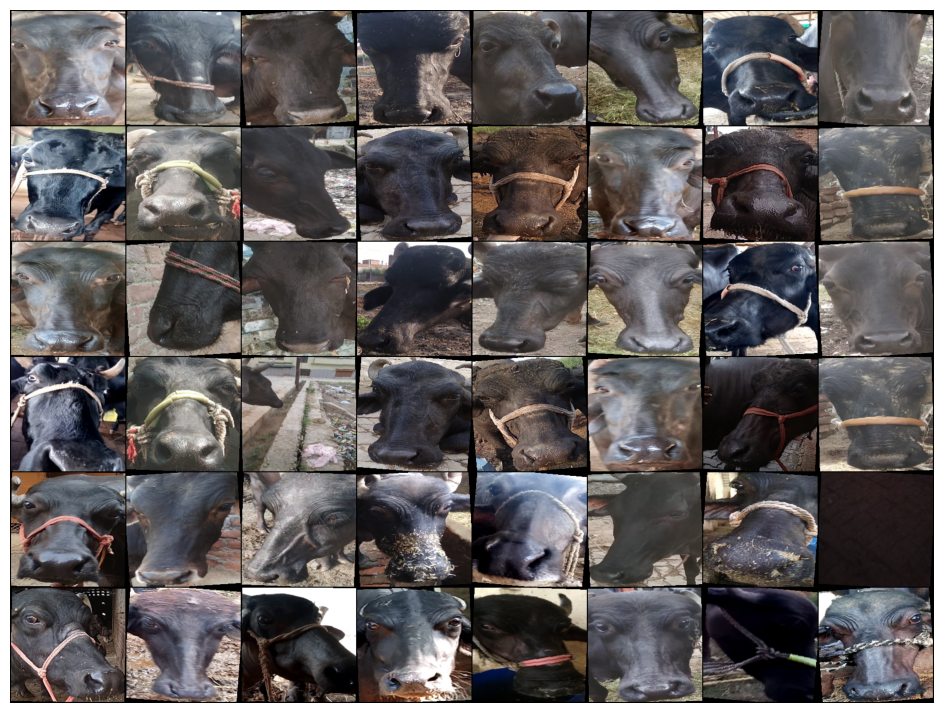

In [9]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
print(anch_imgs.shape, pos_imgs.shape)
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

In [10]:
class TripletNetwork(nn.Module):

    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.classifier[2].in_features
        #model.fc
        model.classifier[2] = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, embed_size))
        self.model = model

    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

    def forward_one(self, img):
        f_img = self.model(img)
        return f_img

In [11]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))
        return loss

In [12]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()

    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0

    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)

        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))

    print()

    return model, avg_loss


def validate_step(model, valid_dl, criterion, device):
    model.eval()

    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0

    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

            f_anc, f_pos, f_neg = model(anc, pos, neg)
            loss = criterion(f_anc, f_pos, f_neg)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()

    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()

    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}\n--------')

        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history

In [13]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# model
cnn = get_model(cnn_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# loss and optimizer
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:02<00:00, 68.2MB/s]


In [14]:
model, best_weights, loss_hist = train(model,
                                       train_dl, valid_dl,
                                       criterion, optimizer,
                                       device,
                                       scheduler,
                                       num_epochs=3)

Epoch 1
--------
 Training Step [737/736]: loss 8.75561  
 Validation Step [211/210]: loss 2.72465  

Epoch 2
--------
 Training Step [737/736]: loss 2.88932  
 Validation Step [211/210]: loss 3.45954  

Epoch 3
--------
 Training Step [737/736]: loss 2.16749  
 Validation Step [211/210]: loss 3.06308  



In [15]:
torch.save(model.state_dict(), '/content/gdive/MyDrive/Gautam Cattle/convnxt_small_buffalo.pt')
#model.load_state_dict(torch.load('/content/gdive/MyDrive/Gautam Cattle/convnxt_small_256.pt'))

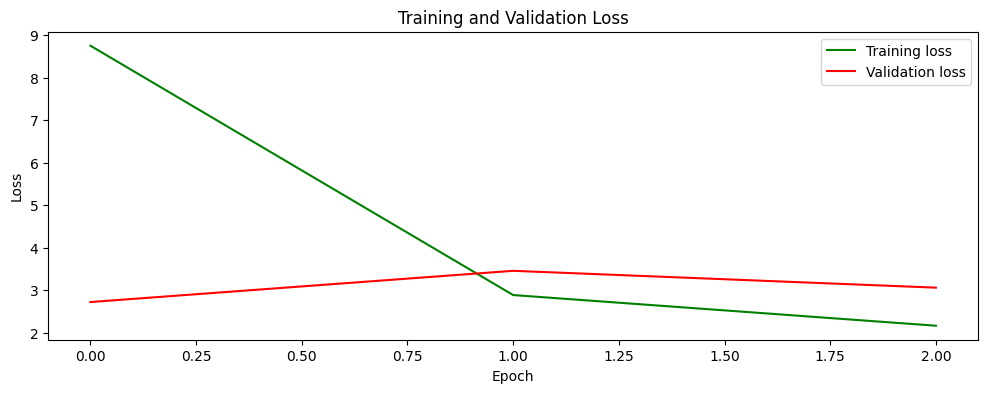

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

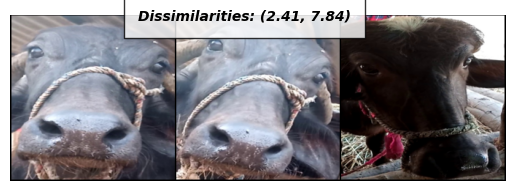

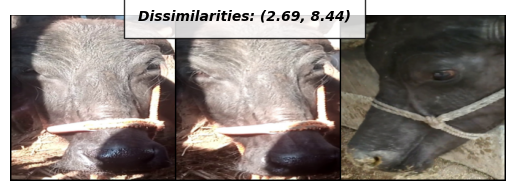

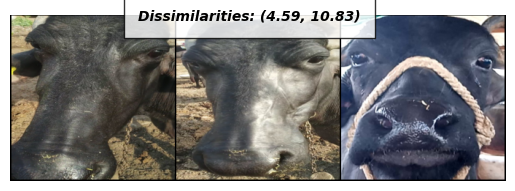

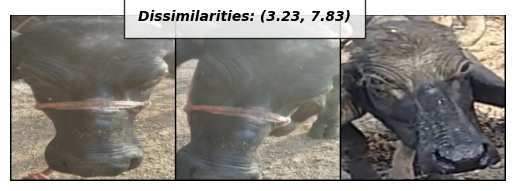

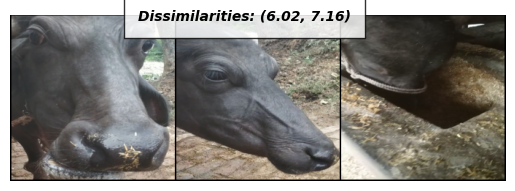

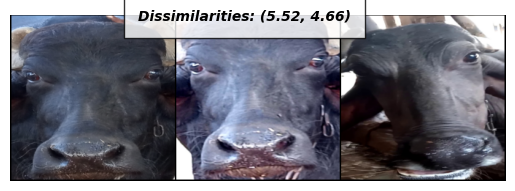

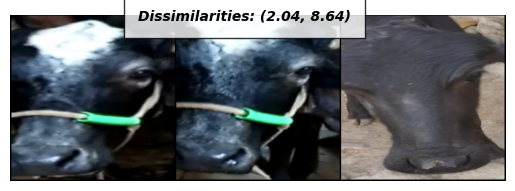

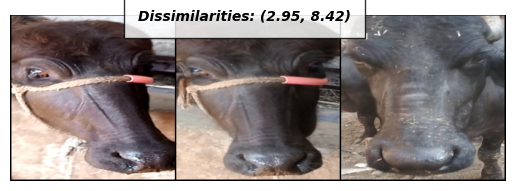

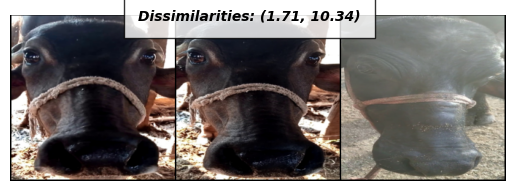

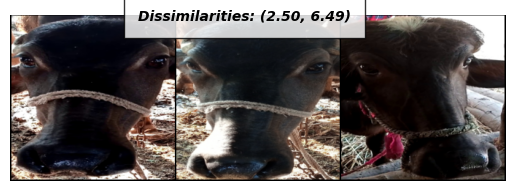

In [17]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(10):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')

In [18]:
dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(2):
        x0, x1, x2 = next(dataiter)
        print(x0.shape, x1.shape, x2.shape)

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


In [20]:
my_path = '/content/content/buffalo_data/val/'
files = list(os.listdir(my_path))

def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [ ]:
correct = 0
total = 0

#def Evaluation(model, threshold = 0.36, num_negative_samples = 50):
model.eval()

with torch.no_grad():
    for i in files:
        cnt = 0
        img0 = pil_loader(my_path + i + '/' + os.listdir(my_path+i)[0])
        img1 = pil_loader(my_path + i + '/' + os.listdir(my_path+i)[1])
        x0 = valid_tfms(img0).unsqueeze(0)
        x1 = valid_tfms(img1).unsqueeze(0)
        for j in files:
            cnt+=1
            if i!=j:
                #x0, x1, x2 = next(dataiter)
                img2 = pil_loader(my_path + j + '/' + os.listdir(my_path+j)[0])
                x2 = valid_tfms(img2).unsqueeze(0)
                concat = torch.cat((x0, x1, x2), 0)
                f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
                pos_distance = F.pairwise_distance(f0, f1)
                neg_distance = F.pairwise_distance(f0, f2)
                if pos_distance.item() > neg_distance.item():
                    print(i,j)
                    break
        if cnt == len(files):
            correct += 1
        total += 1
        print('correct', correct, 'total', total, end = ', ')

#Evaluation(model)
print('\n',correct/200)

75 160
correct 0 total 1, correct 1 total 2, correct 2 total 3, correct 3 total 4, correct 4 total 5, correct 5 total 6, correct 6 total 7, correct 7 total 8, correct 8 total 9, correct 9 total 10, correct 10 total 11, correct 11 total 12, correct 12 total 13, correct 13 total 14, correct 14 total 15, correct 15 total 16, correct 16 total 17, correct 17 total 18, correct 18 total 19, 160 75
correct 18 total 20, correct 19 total 21, correct 20 total 22, correct 21 total 23, correct 22 total 24, correct 23 total 25, correct 24 total 26, correct 25 total 27, correct 26 total 28, 48 105
correct 26 total 29, correct 27 total 30, correct 28 total 31, correct 29 total 32, correct 30 total 33, 681 717
correct 30 total 34, correct 31 total 35, correct 32 total 36, correct 33 total 37, correct 34 total 38, correct 35 total 39, correct 36 total 40, correct 37 total 41, correct 38 total 42, correct 39 total 43, 799 460
correct 39 total 44, correct 40 total 45, correct 41 total 46, correct 42 total

In [21]:
embeddings, labels = [],[]
model.eval()

with torch.no_grad():
    for i in files:
        for j in range(len(os.listdir(my_path+i))):
            img0 = pil_loader(my_path + i + '/' + os.listdir(my_path+i)[j])
            x0 = valid_tfms(img0).unsqueeze(0)
            f0 = model.forward_one(x0.to(device))
            embeddings.append(f0.cpu().numpy())
            labels.append(i)

In [22]:
len(embeddings)

3361

In [27]:
correct = 0
for i in range(len(embeddings)):
    mini = 20
    cls = -1
    for j in range(len(embeddings)):
        if i!=j:
            dist = np.linalg.norm(embeddings[i]-embeddings[j])
            if dist<mini:
                cls = j
                mini = dist
    if labels[i]==labels[cls]:
        correct += 1
        print('correct', correct, 'total', i, end = ', ')
        continue
    print(i,j)

correct 1 total 0, 1 3360
correct 2 total 2, correct 3 total 3, correct 4 total 4, correct 5 total 5, correct 6 total 6, correct 7 total 7, correct 8 total 8, correct 9 total 9, correct 10 total 10, correct 11 total 11, correct 12 total 12, correct 13 total 13, correct 14 total 14, correct 15 total 15, correct 16 total 16, correct 17 total 17, correct 18 total 18, correct 19 total 19, correct 20 total 20, correct 21 total 21, correct 22 total 22, correct 23 total 23, correct 24 total 24, correct 25 total 25, correct 26 total 26, correct 27 total 27, correct 28 total 28, correct 29 total 29, correct 30 total 30, correct 31 total 31, correct 32 total 32, correct 33 total 33, correct 34 total 34, correct 35 total 35, correct 36 total 36, correct 37 total 37, correct 38 total 38, correct 39 total 39, correct 40 total 40, correct 41 total 41, correct 42 total 42, correct 43 total 43, correct 44 total 44, correct 45 total 45, correct 46 total 46, correct 47 total 47, correct 48 total 48, cor

In [28]:
correct/len(embeddings)

0.9880987801249628